In [2]:
nb_samples = 64
# list_features = ["longitude", "latitude", "groundspeed"] #, "track"] #, "altitude"]
# list_features = ["longitude", "latitude", "track"] #, "track"] #, "altitude"]
list_features = ["longitude", "latitude"]  # , "track"] #, "altitude"]
nb_features = len(list_features)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from traffic.core import Flight, Traffic
from traffic.algorithms.clustering import prepare_features
from traffic.data import airports

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.max_columns", None)

t = Traffic.from_file("./data/resampled_t_near_ap.parquet")
t.data.head()

airport = airports["LSZH"]

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from artefact import Autoencoder
from artefact.clustering import get_latent
from artefact.training import train
from artefact.plot import plot_loss, plot_latent, plot_latent_and_trajs

np.random.seed(0)

torch.manual_seed(0)

/Users/arthur/Dev/OpenAirlines/artefact/artefact/training.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [140]:
t.data["runway_name"].value_counts()

runway_name
28    167488
32     70400
16     32960
10      7168
34      5632
14        64
Name: count, dtype: int64

In [6]:
t_f = Traffic(t.data.copy())
t_f = t_f.query("runway_name == '28'")

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))

features = t_f.data[list_features].values  # type: ignore
scaler = scaler.fit(features)  # fits on the axis 0

features = scaler.transform(features)
features_shape = features.shape
X = features.ravel()
print(f"X shape: {X.shape}")
print(f"features shape: {features_shape}")
print(f"scaler data min: {scaler.data_min_}, max: {scaler.data_max_}, range: {scaler.data_range_}")

X shape: (334976,)
features shape: (167488, 2)
scaler data min: [ 8.544617 47.440933], max: [ 8.570503 47.467678], range: [0.025886 0.026745]


In [8]:
def prepare_features_new(
    *,
    list_features,
    scaler: MinMaxScaler,
    traffic: Traffic,
    flight_idx: list[str] | None = None,
    nb_samples: int = 64,
):
    if flight_idx is not None:
        traffic = traffic[flight_idx]  # type: ignore

    X = np.empty((len(traffic), nb_samples * len(list_features)))
    flight_idx_order = []
    for idx, flight in enumerate(traffic):
        # _X = np.empty((len(list_features), nb_samples))

        _X_unscaled = flight.data[list_features]

        _X = scaler.transform(_X_unscaled)

        X[idx] = _X.reshape(-1)
        flight_idx_order.append(flight.flight_id)

    return X, flight_idx_order

In [9]:
X, *_ = prepare_features_new(list_features=list_features, scaler=scaler, traffic=t_f)
display(X)
X.shape

array([[-0.1233099 ,  0.59521406, -0.13659893, ...,  0.17674332,
         0.86633702,  0.18003365],
       [-0.16843081,  0.6174986 , -0.17569343, ...,  0.27141522,
         0.72077571,  0.27141522],
       [-0.13791239,  0.61061881, -0.14579309, ...,  0.17584595,
         0.87035463,  0.18003365],
       ...,
       [-0.04921579,  0.00512245, -0.04643437, ...,  0.17741634,
         0.91393031,  0.1783137 ],
       [-0.09549563, -0.00213124, -0.09147802, ...,  0.17569639,
         0.90303639,  0.1783137 ],
       [ 0.05833269,  0.05522528,  0.07185351, ...,  0.17928585,
         0.96291432,  0.18018321]])

(2617, 128)

In [10]:
from pathlib import Path


def plot_reconstruction(
    flight_selection: list[str],
    traffic: Traffic,
    model: Autoencoder,
    save_dir: Path = Path("./data/plots/reconstructions/"),
    show_plots=False,
):
    features, flight_selection = prepare_features_new(
        list_features=list_features, scaler=scaler, traffic=t_f, flight_idx=flight_selection
    )

    features = torch.as_tensor(features, dtype=torch.float32, device="cpu")

    model.to("cpu")
    model.eval()

    with torch.no_grad():
        lat, output = model(features)
        lat = lat.cpu().numpy()
        output = output.cpu().numpy()

    for i, flight_id in enumerate(flight_selection):
        flight_original = traffic[flight_id]

        flight_output = output[i].reshape(-1, len(list_features))
        flight_output = scaler.inverse_transform(flight_output)

        flight_reconstructed = Flight(flight_original.data.copy())
        flight_reconstructed.data[list_features] = flight_output

        with plt.style.context("traffic"):  # type: ignore
            fig, ax = plt.subplots(figsize=(7, 7))

            flight_original.plot(ax, alpha=0.5, label="original", color="green", ls="--")
            flight_reconstructed.plot(ax, alpha=0.5, label="reconstructed", color="k")
            plt.title(f"{flight_original.flight_id}")
            # print(flight_original.flight_id)
            # plt.show()
            plt.savefig(save_dir / f"{flight_original.flight_id}.png")
            if show_plots:
                plt.show()
            plt.close()

In [145]:
X = np.nan_to_num(X, nan=0.0)
X.dtype
X = X.astype(np.float32)

In [11]:
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm.autonotebook import tqdm


def train(
    model,
    X,
    device,
    batch_size=1000,
    lambda_kl=0.0,
    distance_trajectory="euclidean",
    lr=1e-3,
    weight_decay=1e-5,
    epochs=5000,
):
    model.to(device)
    model.train()
    with torch.enable_grad():
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        dataset = TensorDataset(torch.Tensor(X))
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            sampler=None,
            drop_last=True,
            num_workers=6,
        )

        loss_evolution, re_evolution, kl_evolution = [], [], []
        epoch_loss = []

        for epoch in tqdm(range(epochs)):
            epoch_loss.append(0)

            for batch in tqdm(dataloader, desc="batches", leave=False, unit="batch"):
                optimizer.zero_grad()

                v = batch[0].to(device)

                # for iteration in tqdm(range(nb_iterations), leave=False):

                lat, output = model(v)
                # distance = nn.MSELoss(reduction="none")(output, v).sum(1).sqrt()

                loss = criterion(output, v)

                loss_evolution.append(loss.cpu().item())

                loss.backward()
                optimizer.step()

                epoch_loss[-1] += loss.cpu().item()

            # print(f"Epoch {epoch} loss: {epoch_loss[-1]}")

    return (
        model,
        {"loss": loss_evolution, "re_loss": re_evolution, "kl_loss": kl_evolution, "epoch_loss": epoch_loss},
    )

In [12]:
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm.autonotebook import tqdm


def train_(
    model,
    X,
    device,
    nb_iterations,
    batch_size=1000,
    lambda_kl=0.05,
    distance_trajectory="euclidean",
    lr=1e-3,
    weight_decay=1e-5,
    epochs=1,
):
    model.to(device)
    model.train()
    with torch.enable_grad():
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        dataset = TensorDataset(torch.Tensor(X))
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            sampler=None,
            num_workers=4,
        )

        loss_evolution, re_evolution, kl_evolution = [], [], []

        for batch in tqdm(dataloader, desc="batches", leave=True, unit="batch"):
            v = batch[0].to(device)

            # if lambda_kl > 0:
            #     P = torch.as_tensor(make_P(batch[0], metric=distance_trajectory), device=device, dtype=torch.float32)

            for iteration in tqdm(range(nb_iterations), leave=True):
                lat, output = model(v)
                # distance = nn.MSELoss(reduction="none")(output, v).sum(1).sqrt()

                loss = criterion(output, v)

                # if lambda_kl > 0:
                #     kl = kl_divergence(lat, P)
                #     re_evolution.append(loss.cpu().item())
                #     kl_evolution.append(kl.cpu().item())
                #     loss += lambda_kl * kl

                loss_evolution.append(loss.cpu().item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    return (
        model,
        {"loss": loss_evolution, "re_loss": re_evolution, "kl_loss": kl_evolution},
    )

In [13]:
flight_selection = ["SWR641U_4038", "SWR101C_1466", "THY4341_6440", "PGT7114_6603", "SWR1326_6227"]

In [1]:
import os

print(os.environ["MLFLOW_TRACKING_URI"], os.environ["MLFLOW_TRACKING_USERNAME"])

https://mlapp-nkxq44f73a-ez.a.run.app admin-science


In [16]:
import mlflow

# import os


# mlflow.set_tracking_uri("https://mlapp-nkxq44f73a-ez.a.run.app")

experiment = mlflow.set_experiment(experiment_name="trajectory_autoencoder")

model_ = Autoencoder((nb_samples * nb_features, 64, 32, 8, 2))
device = "cpu"

with mlflow.start_run(
    experiment_id=experiment.experiment_id,
    run_name="test2",
    nested=True,
):
    nb_iterations = 1000
    batch_size = X.shape[0]
    lambda_kl = 0

    mlflow.log_params(
        {
            "encoder": str(model_.encoder),
            "decoder": str(model_.decoder),
            "nb_samples": nb_samples,
            "nb_features": nb_features,
            "nb_iterations": nb_iterations,
            "batch_size": batch_size,
            "lambda_kl": lambda_kl,
            "n_flights": len(t_f),
            # "distance_trajectory": distance_trajectory,
            # "lr": lr,
            # "weight_decay": weight_decay,
            # "epochs": epochs,
        }
    )
    model_, metrics = train_(
        model_,
        X,
        device,
        nb_iterations,
        batch_size,
        lambda_kl,
        # distance_trajectory,
        # lr,
        # weight_decay,
        # epochs,
    )
    # mlflow.log_metrics("loss", metrics["loss"])
    mlflow.log_metric("last_loss", metrics["loss"][-1])
    # mlflow.log_metric("re_loss", metrics["re_loss"][-1])
    # mlflow.log_metric("kl_loss", metrics["kl_loss"][-1])
    # mlflow.log_artifact("test.ipynb")

    if True:
        latent = get_latent(X, model_, device)

        fig = plt.figure()
        # ax = fig.add_subplot(projection='3d')
        ax = fig.add_subplot()
        # ax.scatter(latent[:, 0], latent[:, 1],c=latent[:, 2])
        # ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2])
        ax.scatter(latent[:, 0], latent[:, 1])
        plt.savefig(f"./data/plots/latent/{mlflow.active_run().info.run_name}.png")
        plt.close()
        mlflow.log_artifact(f"./data/plots/latent/{mlflow.active_run().info.run_name}.png")

    if True:
        img_save_path = Path(f"./data/plots/reconstructions/{mlflow.active_run().info.run_name}/")
        img_save_path.mkdir(parents=True, exist_ok=True)
        plot_reconstruction(flight_selection, t_f, model_, img_save_path)
        mlflow.log_artifact(img_save_path)

encoder Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=2, bias=True)
  (7): ReLU()
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=128, bias=True)
  (7): Tanh()
)


batches:   0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

InvalidOperation: Anonymous credentials cannot be refreshed.

In [240]:
# model_ = Autoencoder((nb_samples * nb_features, 64, 32, 8, 2))
# model_ = Autoencoder((nb_samples * nb_features, 32, 8, 2), dropout=0.1)
model_ = Autoencoder((nb_samples * nb_features, 64, 32, 8, 2))

device = "cpu"
device = "mps"
# model, loss = train(
#     # model_, X, device=device, nb_iterations=5000, batch_size=len(X), lambda_kl=0, epochs=1, distance_trajectory="euclidean"
#     model_,
#     X,
#     device=device,
#     # nb_iterations=5000,
#     # batch_size=len(X),
#     lambda_kl=0,
#     epochs=100,
#     # batch_size=500,
#     batch_size=X.shape[0],
#     lr=1e-3,
#     # distance_trajectory="directed_hausdorff"
#     # model_, X, device=device, nb_iterations=5000, batch_size=len(X), lambda_kl=0, epochs=3, distance_trajectory="euclidean"
# )

model, loss = train_(
    # model_, X, device=device, nb_iterations=5000, batch_size=len(X), lambda_kl=0, epochs=1, distance_trajectory="euclidean"
    model_,
    X,
    device=device,
    nb_iterations=10000,
    # nb_iterations=5000,
    # batch_size=len(X),
    # batch_size=500,
    batch_size=X.shape[0],
    # distance_trajectory="directed_hausdorff"
    # model_, X, device=device, nb_iterations=5000, batch_size=len(X), lambda_kl=0, epochs=3, distance_trajectory="euclidean"
)

encoder Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=2, bias=True)
  (7): ReLU()
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=128, bias=True)
  (7): Tanh()
)


batches: 100%|██████████| 1/1 [02:16<00:00, 136.57s/batch]


In [51]:
model_ = Autoencoder((nb_samples * nb_features, 64, 32, 8, 2))

device = "cpu"
model, loss = train(
    model_,
    X,
    device=device,
    nb_iterations=10000,
    batch_size=len(X),
    lambda_kl=0,
    epochs=1,
    distance_trajectory="euclidean",
)

dropout!
encoder Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Dropout(p=0.25, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=8, bias=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=2, bias=True)
  (10): Dropout(p=0.25, inplace=False)
  (11): ReLU()
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=32, bias=True)
  (4): Dropout(p=0.25, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=64, bias=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=128, bias=True)
  (10): Dropout(p=0.25, inplace=False)
  (11): Sigmoid()
)


  0%|          | 0/1 [00:00<?, ?it/s]

batches:   0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

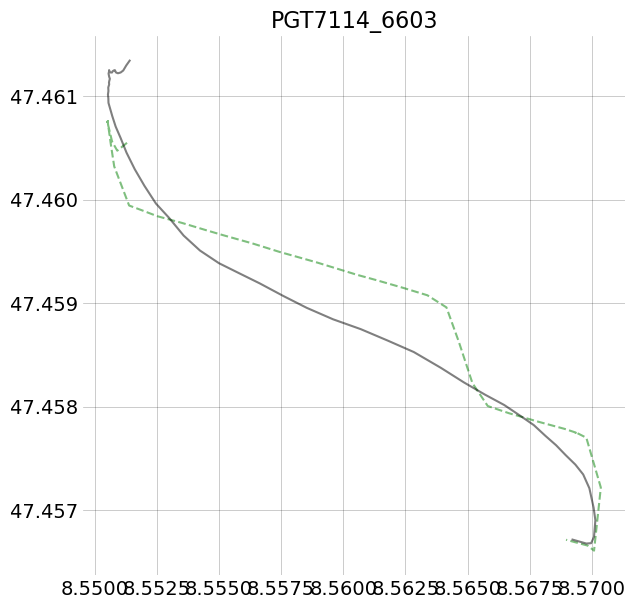

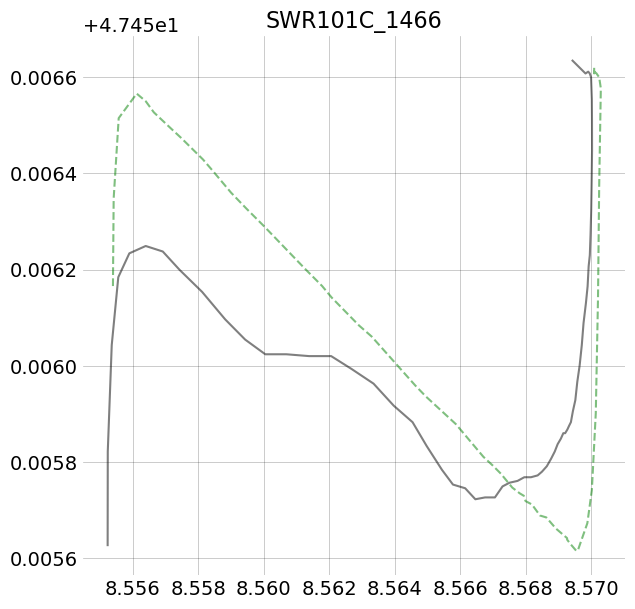

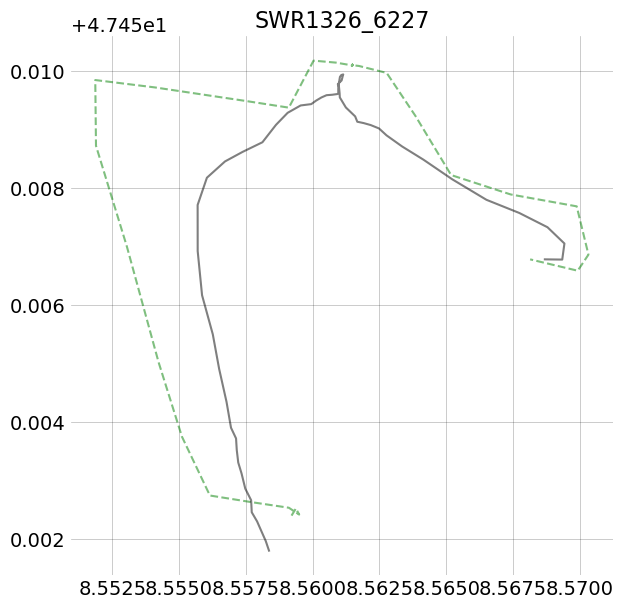

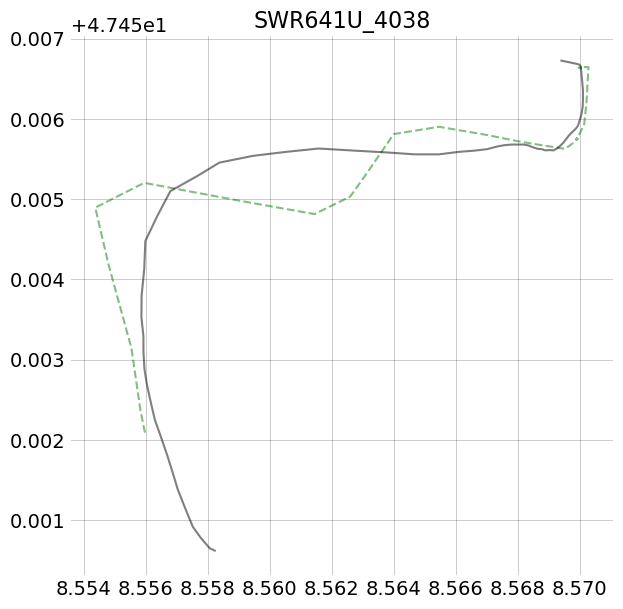

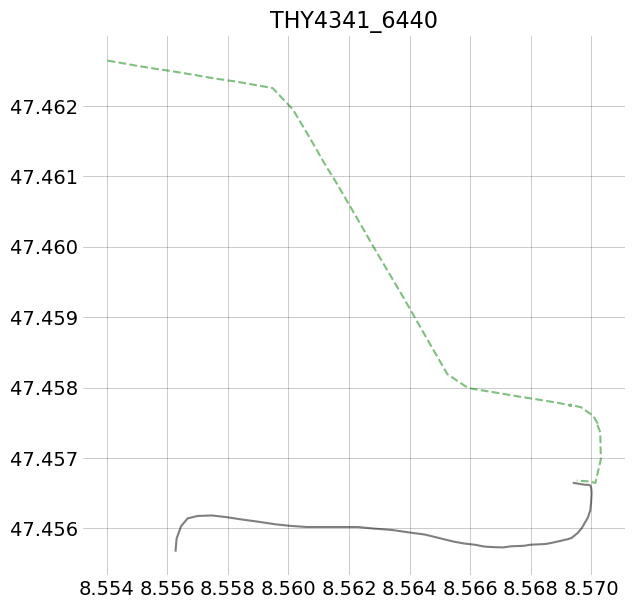

In [375]:
plot_reconstruction(flight_selection, t_f, model, show_plots=True)

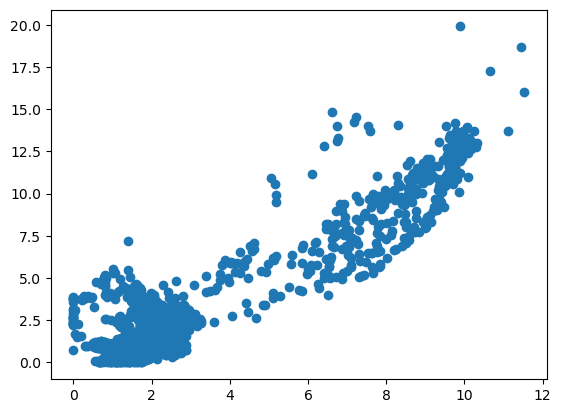

In [241]:
# latent = get_latent(X, model, device)
model.eval()
latent = get_latent(X, model, device)

%matplotlib inline
# %matplotlib widget
# %matplotlib ipympl

# plt.interactive(True)

fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
# ax.scatter(latent[:, 0], latent[:, 1],c=latent[:, 2])
# ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2])
ax.scatter(latent[:, 0], latent[:, 1])
plt.show()

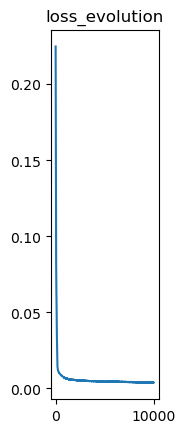

In [243]:
plot_loss(
    loss["loss"],
)  # epoch_loss=loss["epoch_loss"])
plt.show()

In [209]:
t_f

,count
flight_id,
AAL93_7720,64
SWR25P_4024,64
SWR252H_6245,64
SWR252H_6246,64
SWR2530_3232,64
SWR253J_1323,64
SWR253J_1371,64
SWR253J_1539,64
SWR253J_1743,64


In [244]:
flights_ids = t_f.flight_ids

In [70]:
%matplotlib inline

-0.18742281 0.9165241
(64, 2)
SWR1326_6227


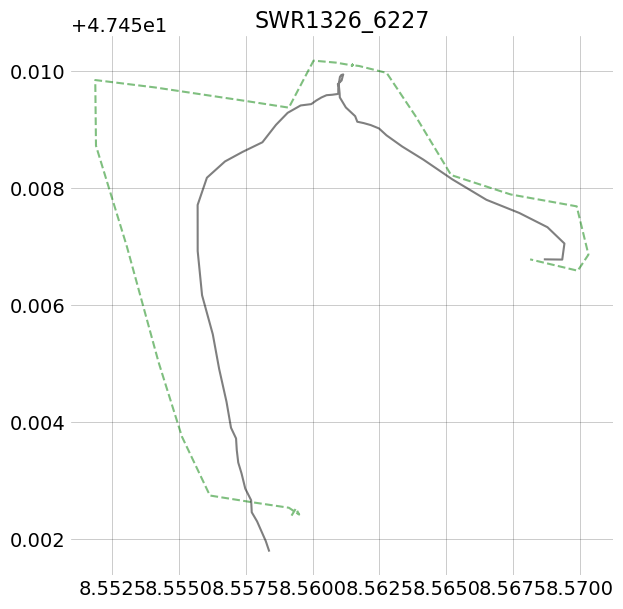

In [358]:
flight = t_f[np.random.choice(flights_ids, 1)]

flight_original = Flight(flight.data.copy())

flight_X = flight.data[list_features].values

flight_X = scaler.transform(flight_X)
flight_X = torch.as_tensor(flight_X.reshape(1, -1), dtype=torch.float32, device=device)

model.eval()
flight_Y = model(flight_X)[1].cpu().detach().numpy()
print(np.min(flight_Y), np.max(flight_Y))
flight_Y = scaler.inverse_transform(flight_Y.reshape(-1, len(list_features)))

flight_Y_reshaped = flight_Y.reshape(-1, len(list_features))

flight_reconstructed = Flight(flight.data.copy())
flight_reconstructed.data[list_features] = flight_Y_reshaped
print(flight_Y_reshaped.shape)

with plt.style.context("traffic"):  # type: ignore
    fig, ax = plt.subplots(figsize=(7, 7))

    flight_original.plot(ax, alpha=0.5, label="original", color="green", ls="--")
    flight_reconstructed.plot(ax, alpha=0.5, label="reconstructed", color="k")
    plt.title(f"{flight_original.flight_id}")
    print(flight_original.flight_id)
    plt.show()

# plt.scatter(
#     range(flight_original.data.shape[0]),
#     flight_original.data["groundspeed"],
#     color="green",
#     alpha=0.5,
#     label="original",
#     ls="--",
# )
# plt.scatter(
#     range(flight_original.data.shape[0]),
#     flight_reconstructed.data["groundspeed"],
#     color="k",
#     alpha=0.5,
#     label="reconstructed",
#     ls="--",
# )
# plt.show()

In [330]:
flight_X.shape

torch.Size([1, 192])

In [332]:
test = flight_X.cpu().numpy()
test = test.reshape(-1)
display(test[::3])
display(test[1::3])
display(test[2::3])

array([ 2.6750740e-02,  2.7227247e-02,  3.2621246e-02,  1.8655438e-02,
       -8.2652858e-03,  5.0591878e-03,  1.8579446e-02,  2.5130941e-02,
        3.0024862e-02,  3.1320017e-02, -1.1590321e-01, -3.3164018e-01,
       -4.5006448e-01, -5.5178750e-01, -5.4661810e-01, -5.5422992e-01,
       -5.8414680e-01, -5.9195703e-01, -7.2411722e-01, -8.9104658e-01,
       -8.7077928e-01, -8.8706630e-01, -9.0412426e-01, -9.0477824e-01,
       -9.0178722e-01, -9.0330744e-01, -9.0260464e-01, -9.0402955e-01,
       -9.0176314e-01, -9.0425533e-01, -9.0419829e-01, -9.0426809e-01,
       -9.0423936e-01, -9.0323275e-01, -9.0190947e-01, -9.0345240e-01,
       -9.0446842e-01, -9.0367109e-01, -8.9799309e-01, -7.5508434e-01,
       -7.6923382e-01, -9.1331041e-01, -1.0000000e+00, -1.0000000e+00,
       -1.0000000e+00, -1.0000000e+00, -7.8606802e-01, -6.3731670e-01,
       -5.3624398e-01, -3.8140368e-01,  4.1535139e-04,  3.3242768e-01,
        6.9066262e-01,  9.1430593e-01,  9.7094083e-01,  9.8938894e-01,
      

array([ 0.22498167,  0.27300978,  0.27802607,  0.27429038,  0.27003264,
        0.2638037 ,  0.2423638 ,  0.23133048,  0.22321194,  0.21827587,
        0.22502172,  0.23961772,  0.21028922,  0.25925037,  0.25757816,
        0.26489857,  0.3068267 ,  0.39968354,  0.5921728 ,  0.8194185 ,
        0.9034147 ,  0.98094404,  0.9998406 ,  1.        ,  0.99546933,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.99799025,  0.9980803 ,  0.9998399 ,  1.        ,
        1.        ,  1.        ,  0.9905025 ,  0.9419498 ,  0.8947653 ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.997113  ,
        0.74635303,  0.3701414 ,  0.2376305 ,  0.18793175,  0.16892011,
        0.07520985, -0.00106952,  0.02764437,  0.13984469,  0.34098384,
        0.34051108,  0.35253304,  0.35759807,  0.37779865,  0.56446946,
        0.59860307,  0.7017169 ,  0.7017169 ,  0.7851076 ], dtype=float32)

array([-0.9783296 , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -0.9548533 , -0.9548533 , -0.9548533 , -1.        , -0.9986456 ,
       -0.9783296 , -0.9548533 , -0.9548533 , -0.88487583, -0.90293455,
       -0.9548533 , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -0.9548533 , -0.9548533 , -0.9548533 , -0.9548533 ,
       -0.90970653, -0.90970653, -0.90970653, -0.9548533 , -0.90970653,
       -0.89841986, -0.88487583, -0.90970653, -0.95124155, -0.9693002 ,
       -0.99819416, -0.99819416, -0.99819416, -0.9900677 , -0.9900677 ,
       -0.96749437, -0.9986456 , -0.9986456 , -0.89841986], dtype=float32)

In [156]:
flight_Y.shape

(1, 192)

In [81]:
flight_Y.shape

(1, 128)

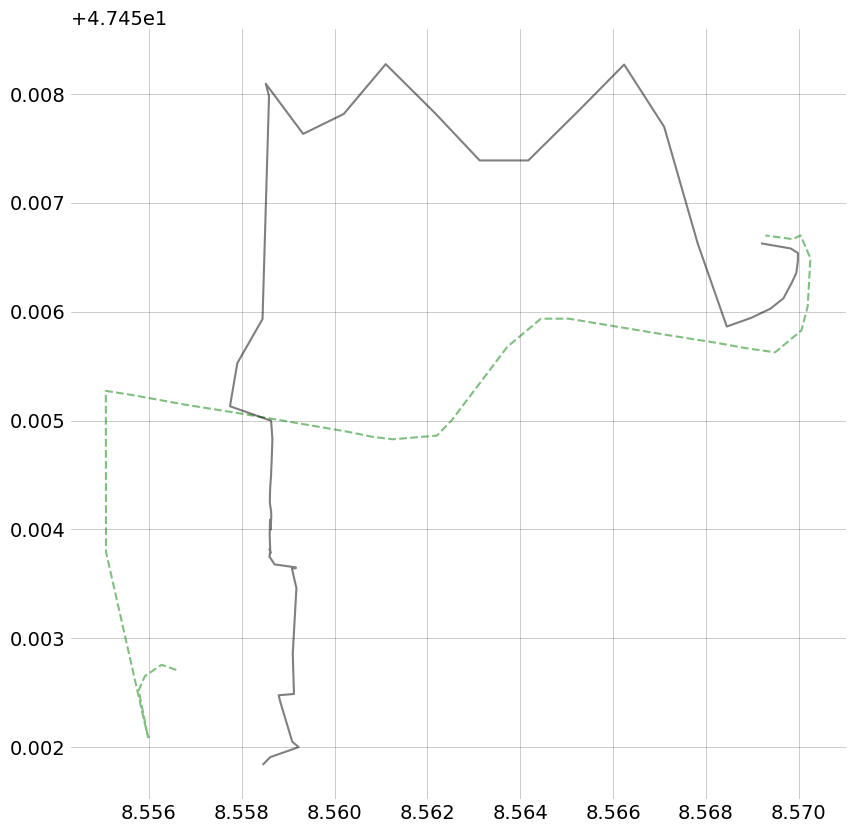

In [79]:
with plt.style.context("traffic"):  # type: ignore
    fig, ax = plt.subplots(figsize=(10, 10))

    flight_original.plot(ax, alpha=0.5, label="original", color="green", ls="--")
    flight_reconstructed.plot(ax, alpha=0.5, label="reconstructed", color="k")

In [337]:
flight_X = prepare_features(
    Traffic.from_flights([flight]),
    nb_samples=None,
    features=list_features,
)

flight_X = scaler.transform(flight_X)
flight_X = flight_X.reshape(-1)

In [339]:
list_features

['longitude', 'latitude', 'groundspeed']

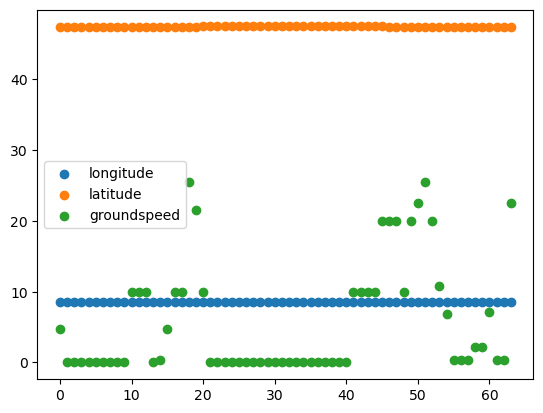

In [344]:
plt.scatter(range(64), flight.data["longitude"], label="longitude")
plt.scatter(range(64), flight.data["latitude"], label="latitude")
plt.scatter(range(64), flight.data["groundspeed"], label="groundspeed")
plt.legend()

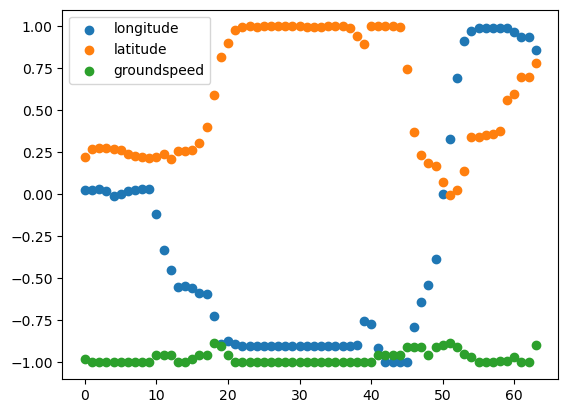

In [341]:
plt.scatter(range(len(flight_X) // 3), flight_X[0::3], label="longitude")
plt.scatter(range(len(flight_X) // 3), flight_X[1::3], label="latitude")
plt.scatter(range(len(flight_X) // 3), flight_X[2::3], label="groundspeed")
plt.legend()

In [347]:
help(scaler)

Help on MinMaxScaler in module sklearn.preprocessing._data object:

class MinMaxScaler(sklearn.base.OneToOneFeatureMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  MinMaxScaler(feature_range=(0, 1), *, copy=True, clip=False)
 |  
 |  Transform features by scaling each feature to a given range.
 |  
 |  This estimator scales and translates each feature individually such
 |  that it is in the given range on the training set, e.g. between
 |  zero and one.
 |  
 |  The transformation is given by::
 |  
 |      X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
 |      X_scaled = X_std * (max - min) + min
 |  
 |  where min, max = feature_range.
 |  
 |  This transformation is often used as an alternative to zero mean,
 |  unit variance scaling.
 |  
 |  Read more in the :ref:`User Guide <preprocessing_scaler>`.
 |  
 |  Parameters
 |  ----------
 |  feature_range : tuple (min, max), default=(0, 1)
 |      Desired range of transformed data.
 |  
 |  copy : b